# LLM Classification with Random Forest

## Generate the accuracy Distribution with Bootstrapping

In [1]:
import pandas as pd
import pickle
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


In [2]:
# CREATING STYLOMETRIC FEATURES and embeddings DATSET

with open('cls_emb.pkl', 'rb') as f:
    cls = pickle.load(f)
with open('feature_vectors.pkl', 'rb')as f:
    feature_vectors= pickle.load(f)

response_df = pd.read_csv('final_data.csv')

embeddings = [torch.cat((cls[i].float(), torch.from_numpy(feature_vectors[i]).unsqueeze(0).float()), dim=1) for i in range(len(cls))]

# Concatenate the tensors vertically
concatenated_tensor = torch.cat(embeddings, dim=0)


np_df = concatenated_tensor.numpy()

df = pd.DataFrame(np_df)

df["temperature"] = list(response_df["temperature"])
df["model"] = list(response_df["model"])
df["hash"] = list(response_df["hash"])

df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,temperature,model,hash
0,-0.808103,-0.695130,-0.998995,0.744438,0.934451,-0.524138,-0.222032,0.534780,-0.996766,-0.999960,...,0.174524,0.0,0.0,0.013076,0.305416,0.001028,0.000823,0.0,llama3.1-70b,0afa4f79948ca719177ddf4ad11a6019
1,-0.714722,-0.625432,-0.997753,0.501705,0.931522,-0.370452,-0.393409,0.443065,-0.994150,-0.999931,...,0.188972,0.0,0.0,0.016121,0.350949,0.001104,0.000951,0.7,llama3.1-70b,0afa4f79948ca719177ddf4ad11a6019


In [3]:
X = df.iloc[:, :797]
y = df[["model", "temperature"]]

In [4]:
# Extract test and split
X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract 10% to be unseen for final test
X_test, X_F_test, y_test_temp, y_F_test_temp = train_test_split(X_test, y_test_temp, test_size=0.1, random_state=42)

# Take only the model, the temperature column is used for bootstraping section
y_test = y_test_temp["model"]
y_F_test = y_F_test_temp["model"]
y_train = y_train_temp["model"]

laberl_encoder = LabelEncoder()
y_train = laberl_encoder.fit_transform(y_train)
y_test = laberl_encoder.transform(y_test)

y_test.shape, y_F_test.shape, y_train.shape

((2635,), (293,), (11709,))

In [5]:
dbscan = DBSCAN(eps=2)

cluster_train = dbscan.fit_predict(X_train)
cluster_test = dbscan.fit_predict(X_test)

### Bootstrapping

In [6]:
test_full_df = pd.concat([X_F_test, y_F_test_temp], axis=1).reset_index().drop(columns=['index'])
temp_0_idx = test_full_df[test_full_df["temperature"] == 0.0].index
temp_07_idx = test_full_df[test_full_df["temperature"] == 0.7].index
temp_14_idx = test_full_df[test_full_df["temperature"] == 1.4].index
temp_all_idx = test_full_df.index


dbscan = DBSCAN(eps=2)

cluster_train = dbscan.fit_predict(X_train)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


# Fit PCA on the standardized training data
pca = PCA(n_components=22, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)


# scale clusters
scaler2 = StandardScaler()
cluster_train = scaler2.fit_transform(cluster_train.reshape(-1, 1))


# Adding clustered
X_train_pca = np.concatenate((X_train_pca, cluster_train.reshape(-1,1)), axis=1)



rfc = RandomForestClassifier(random_state=42, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=300)
rfc.fit(X_train_pca, y_train)

list_lists_temps = []


for temp_idexs in [temp_0_idx, temp_07_idx, temp_14_idx, temp_all_idx]:
    
    bootstrap_list = []
    
    for _ in tqdm(range(1000)):
        
        bootstrap_indexes = list(np.random.choice(temp_idexs, size=1000, replace=True))
        
        X_boot = test_full_df.iloc[bootstrap_indexes].iloc[:,:797]
        y_boot = test_full_df.iloc[bootstrap_indexes]["model"]

        y_boot = laberl_encoder.transform(y_boot)


        cluster_test = dbscan.fit_predict(X_boot)
        X_test_scaled = scaler.transform(X_boot)
        
        # Apply the same transformation to the standardized test data
        X_test_pca = pca.transform(X_test_scaled)
        
        cluster_test = scaler2.transform(cluster_test.reshape(-1, 1))
        
        X_test_pca = np.concatenate((X_test_pca, cluster_test.reshape(-1,1)), axis=1)
        
        
        # Step 3: Predict and evaluate the classifier
        y_pred = rfc.predict(X_test_pca)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_boot, y_pred)

        bootstrap_list.append(accuracy)
        
    list_lists_temps.append(bootstrap_list)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:26<00:00,  2.24it/s]


In [7]:
bootstrapping_00 = np.array(list_lists_temps[0]) * 100
bootstrapping_07 = np.array(list_lists_temps[1]) * 100
bootstrapping_14 = np.array(list_lists_temps[2]) * 100
bootstrapping_all = np.array(list_lists_temps[3]) * 100

In [8]:
bootstrapping_00.mean(), bootstrapping_07.mean(), bootstrapping_14.mean(), bootstrapping_all.mean()

(56.9733, 53.4528, 56.0849, 56.530100000000004)

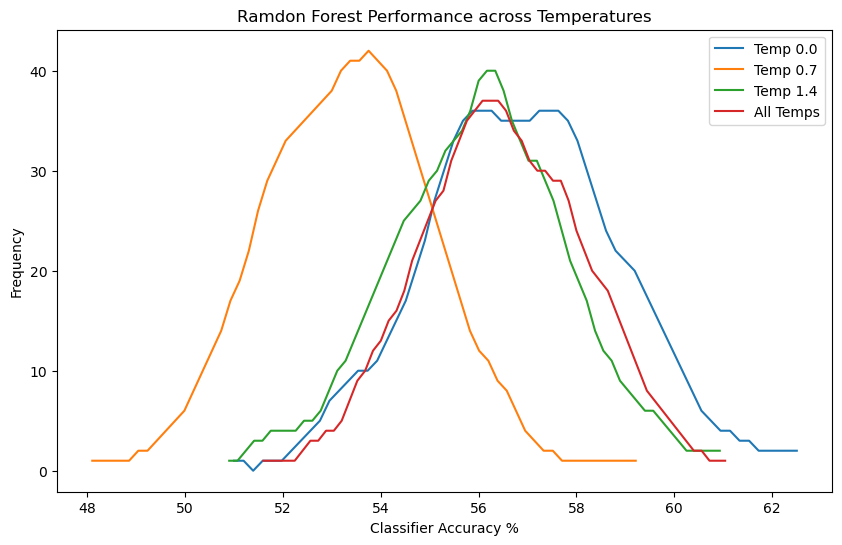

In [9]:
# Generate the plot

bins = 60

# Create histogram data
counts1, bins1 = np.histogram(bootstrapping_00, bins=bins)
counts2, bins2 = np.histogram(bootstrapping_07, bins=bins)
counts3, bins3 = np.histogram(bootstrapping_14, bins=bins)
counts4, bins4 = np.histogram(bootstrapping_all, bins=bins)

smoothed_counts1 = gaussian_filter1d(counts1, sigma=2)
smoothed_counts2 = gaussian_filter1d(counts2, sigma=2)
smoothed_counts3 = gaussian_filter1d(counts3, sigma=2)
smoothed_counts4 = gaussian_filter1d(counts4, sigma=2)

plt.figure(figsize=(10, 6))

# Plot the line histograms
plt.plot(bins1[:-1], smoothed_counts1, linestyle='-', label='Temp 0.0')
plt.plot(bins2[:-1], smoothed_counts2, linestyle='-', label='Temp 0.7')
plt.plot(bins3[:-1], smoothed_counts3, linestyle='-', label='Temp 1.4')
plt.plot(bins4[:-1], smoothed_counts4, linestyle='-', label='All Temps')


# Add titles and labels
plt.title('Ramdon Forest Performance across Temperatures')
plt.xlabel('Classifier Accuracy %')
plt.ylabel('Frequency')
plt.legend()

plt.savefig('ramdon forest accuracy distribution.jpg', format='jpeg', dpi=300)

# Show the plot
plt.show()

# Appendix

## Run the classifier with the best model parameters

In [1]:
import pandas as pd
import pickle
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from tqdm import tqdm

In [2]:
# CREATING STYLOMETRIC FEATURES and embeddings DATSET

with open('cls_emb.pkl', 'rb') as f:
    cls = pickle.load(f)
with open('feature_vectors.pkl', 'rb')as f:
    feature_vectors= pickle.load(f)

response_df = pd.read_csv('final_data.csv')

embeddings = [torch.cat((cls[i].float(), torch.from_numpy(feature_vectors[i]).unsqueeze(0).float()), dim=1) for i in range(len(cls))]

# Concatenate the tensors vertically
concatenated_tensor = torch.cat(embeddings, dim=0)

# Concatenate the tensors vertically
concatenated_tensor = torch.cat(embeddings, dim=0)

np_df = concatenated_tensor.numpy()

df = pd.DataFrame(np_df)

df["temperature"] = list(response_df["temperature"])
df["model"] = list(response_df["model"])
df["hash"] = list(response_df["hash"])

# Extract X and y
X = df.iloc[:, :797]
y = df[["model", "temperature"]]

# Create train and test subsets
X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, X_F_test, y_test_temp, y_F_test_temp = train_test_split(X_test, y_test_temp, test_size=0.1, random_state=42)

# Take only the model, the temperature column is used for bootstraping section
y_test = y_test_temp["model"]
y_F_test = y_F_test_temp["model"]
y_train = y_train_temp["model"]

laberl_encoder = LabelEncoder()
y_train = laberl_encoder.fit_transform(y_train)
y_test = laberl_encoder.transform(y_test)


# Cluestring for improved accuracy
dbscan = DBSCAN(eps=2)

cluster_train = dbscan.fit_predict(X_train)
cluster_test = dbscan.fit_predict(X_test)


# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit PCA on the standardized training data
pca = PCA(n_components=22, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)


# Apply the same transformation to the standardized test data
X_test_pca = pca.transform(X_test_scaled)


# scale clusters
scaler2 = StandardScaler()
cluster_train = scaler2.fit_transform(cluster_train.reshape(-1, 1))
cluster_test = scaler2.transform(cluster_test.reshape(-1, 1))

# Adding clustered
X_train_pca = np.concatenate((X_train_pca, cluster_train.reshape(-1,1)), axis=1)
X_test_pca = np.concatenate((X_test_pca, cluster_test.reshape(-1,1)), axis=1)


rfc = RandomForestClassifier(random_state=42, max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=300)
rfc.fit(X_train_pca, y_train)

# Step 3: Predict and evaluate the classifier
y_pred = rfc.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.5521821631878557


## Optimisation

## Run with different PCA values to get the best accuracy values

In [1]:
import pandas as pd
import pickle
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from tqdm import tqdm

In [2]:
# CREATING STYLOMETRIC FEATURES and embeddings DATSET

with open('cls_emb.pkl', 'rb') as f:
    cls = pickle.load(f)
with open('feature_vectors.pkl', 'rb')as f:
    feature_vectors= pickle.load(f)

response_df = pd.read_csv('final_data.csv')

embeddings = [torch.cat((cls[i].float(), torch.from_numpy(feature_vectors[i]).unsqueeze(0).float()), dim=1) for i in range(len(cls))]

# Concatenate the tensors vertically
concatenated_tensor = torch.cat(embeddings, dim=0)

# Concatenate the tensors vertically
concatenated_tensor = torch.cat(embeddings, dim=0)

np_df = concatenated_tensor.numpy()

df = pd.DataFrame(np_df)

df["temperature"] = list(response_df["temperature"])
df["model"] = list(response_df["model"])
df["hash"] = list(response_df["hash"])

# Extract X and y
X = df.iloc[:, :797]
y = df[["model", "temperature"]]

# Create train and test subsets
X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, X_F_test, y_test_temp, y_F_test_temp = train_test_split(X_test, y_test_temp, test_size=0.1, random_state=42)

# Take only the model, the temperature column is used for bootstraping section
y_test = y_test_temp["model"]
y_F_test = y_F_test_temp["model"]
y_train = y_train_temp["model"]

laberl_encoder = LabelEncoder()
y_train = laberl_encoder.fit_transform(y_train)
y_test = laberl_encoder.transform(y_test)


# Cluestring for improved accuracy
dbscan = DBSCAN(eps=2)

cluster_train = dbscan.fit_predict(X_train)
cluster_test = dbscan.fit_predict(X_test)


# Values are the number of features after PCA dimensionality reduction
for i in range(1,26):

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit PCA on the standardized training data
    pca = PCA(n_components=i, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    
    
    # Apply the same transformation to the standardized test data
    X_test_pca = pca.transform(X_test_scaled)
    
    
    # scale clusters
    scaler2 = StandardScaler()
    cluster_train = scaler2.fit_transform(cluster_train.reshape(-1, 1))
    cluster_test = scaler2.transform(cluster_test.reshape(-1, 1))
    
    # Adding clustered
    X_train_pca = np.concatenate((X_train_pca, cluster_train.reshape(-1,1)), axis=1)
    X_test_pca = np.concatenate((X_test_pca, cluster_test.reshape(-1,1)), axis=1)
    
    
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(X_train_pca, y_train)
    
    # Step 3: Predict and evaluate the classifier
    y_pred = rfc.predict(X_test_pca)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    
    print(i, accuracy)

1 0.32485768500948764
2 0.34573055028462996
3 0.35028462998102466
4 0.3984819734345351
5 0.425426944971537
6 0.43795066413662237
7 0.44174573055028465
8 0.4573055028462998
9 0.4679316888045541
10 0.48007590132827327
11 0.4937381404174573
12 0.5013282732447818
13 0.5066413662239089
14 0.5176470588235295
15 0.5191650853889943
16 0.5256166982922201
17 0.5157495256166983
18 0.5309297912713472
19 0.5335863377609108
20 0.5335863377609108
21 0.535483870967742
22 0.5442125237191651
23 0.538899430740038
24 0.5347248576850094
25 0.5404174573055028


## Use grid saecrh to select the best model hyperparameters

In [ ]:
import pandas as pd
import pickle
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from tqdm import tqdm

In [ ]:
# CREATING STYLOMETRIC FEATURES and embeddings DATSET

with open('cls_emb.pkl', 'rb') as f:
    cls = pickle.load(f)
with open('feature_vectors.pkl', 'rb')as f:
    feature_vectors= pickle.load(f)

response_df = pd.read_csv('final_data.csv')

embeddings = [torch.cat((cls[i].float(), torch.from_numpy(feature_vectors[i]).unsqueeze(0).float()), dim=1) for i in range(len(cls))]

# Concatenate the tensors vertically
concatenated_tensor = torch.cat(embeddings, dim=0)

# Concatenate the tensors vertically
concatenated_tensor = torch.cat(embeddings, dim=0)

np_df = concatenated_tensor.numpy()

df = pd.DataFrame(np_df)

df["temperature"] = list(response_df["temperature"])
df["model"] = list(response_df["model"])
df["hash"] = list(response_df["hash"])

# Extract X and y
X = df.iloc[:, :797]
y = df[["model", "temperature"]]

# Create train and test subsets
X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, X_F_test, y_test_temp, y_F_test_temp = train_test_split(X_test, y_test_temp, test_size=0.1, random_state=42)

# Take only the model, the temperature column is used for bootstraping section
y_test = y_test_temp["model"]
y_F_test = y_F_test_temp["model"]
y_train = y_train_temp["model"]

laberl_encoder = LabelEncoder()
y_train = laberl_encoder.fit_transform(y_train)
y_test = laberl_encoder.transform(y_test)


# Cluestring for improved accuracy
dbscan = DBSCAN(eps=2)

cluster_train = dbscan.fit_predict(X_train)
cluster_test = dbscan.fit_predict(X_test)



# Search with grid

highest_accu = 0

# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}


# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# scale clusters
scaler2 = StandardScaler()
cluster_train = scaler2.fit_transform(cluster_train.reshape(-1, 1))
cluster_test = scaler2.transform(cluster_test.reshape(-1, 1))


# 21 and 26 are the PCS features that gave the best result with the previous
# 
for i in range(21,26):

    
    # Fit PCA on the standardized training data
    pca = PCA(n_components=i, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    
    
    # Apply the same transformation to the standardized test data
    X_test_pca = pca.transform(X_test_scaled)
    
    
    # Adding clustered
    X_train_pca = np.concatenate((X_train_pca, cluster_train.reshape(-1,1)), axis=1)
    X_test_pca = np.concatenate((X_test_pca, cluster_test.reshape(-1,1)), axis=1)
    
    
    rfc = RandomForestClassifier(random_state=42)



    # Initialize GridSearchCV with accuracy as the scoring metric
    grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=4, scoring='accuracy')

    # Fit GridSearchCV to the training data
    grid_search.fit(X_train_pca, y_train)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score in train:", grid_search.best_score_)


    # Use the best estimator to make predictions on the test data
    best_rf = grid_search.best_estimator_
    y_pred = best_rf.predict(X_test_pca)
    
    # Calculate the accuracy on the test data
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy with {i} PCA columns:", test_accuracy)

    if test_accuracy > highest_accu:
        print(f"HIHGEST test score: {test_accuracy}")
        highest_accu = test_accuracy
